In [136]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import tqdm
import seaborn as sns

import lightgbm as lgb
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# set options
pd.set_option('max_columns', 300)

# Utility functions

In [90]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap


# Function to calculate the log of the return
def log_return(series):
    return np.log(series).diff()


# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Preprocessing

In [176]:
data_dir = '../input/optiver-realized-volatility-prediction/'

train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train['row_id'] = train['stock_id'].astype(str)  + '-' + train['time_id'].astype(str) 

def pp_book_all(stock_id):
    file_path = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
        
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }

    
    # create_feature_dict で定義した量をaggで適用
    # time_id (同じtime window内)でグループすることで欲しい情報の単位を作る
    # multiindex になるので、columns を再定義して扱いやすくする
    df = df.groupby('time_id').agg(create_feature_dict).reset_index()
    df.columns = ['_'.join(col) for col in df.columns]
    
    df['row_id'] = df['time_id_'].apply(lambda x : f'{stock_id}-{x}')
    df.drop('time_id_', axis=1, inplace=True)
    
    return df


def pp_book(stock_id):
    file_path = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
        
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate spread
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])

    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
    }
    
    def get_feature_window(low, high):
        df_feature = df[(low < df['seconds_in_bucket'] & (df['seconds_in_bucket'] < high))].groupby('time_id').agg(create_feature_dict).reset_index()
        df_feature.columns = [ f'{c[0]}_{c[1]}_{low}_{high}' for c in df_feature.columns]
        
        return df_feature
    
    df_feature_0_600   = get_feature_window(0, 600)
    df_feature_0_150   = get_feature_window(0, 150)
    df_feature_150_300 = get_feature_window(150, 300)
    df_feature_300_450 = get_feature_window(300, 450)
    df_feature_450_600 = get_feature_window(450, 600)
    
    df_feature_0_600 = df_feature_0_600.merge(df_feature_0_150, how='left', left_on='time_id__0_600', right_on='time_id__0_150')
    df_feature_0_600 = df_feature_0_600.merge(df_feature_150_300, how='left', left_on='time_id__0_600', right_on='time_id__150_300')
    df_feature_0_600 = df_feature_0_600.merge(df_feature_300_450, how='left', left_on='time_id__0_600', right_on='time_id__300_450')
    df_feature_0_600 = df_feature_0_600.merge(df_feature_450_600, how='left', left_on='time_id__0_600', right_on='time_id__450_600')
    
    df = df_feature_0_600.copy()
    df.drop(['time_id__0_150', 'time_id__150_300', 'time_id__300_450', 'time_id__450_600'], axis=1, inplace=True)
    
    # create_feature_dict で定義した量をaggで適用
    # time_id (同じtime window内)でグループすることで欲しい情報の単位を作る
    # multiindex になるので、columns を再定義して扱いやすくする
    #df = df.groupby('time_id').agg(create_feature_dict).reset_index()
    #df.columns = ['_'.join(col) for col in df.columns]
    
    df['row_id'] = df['time_id__0_600'].apply(lambda x : f'{stock_id}-{x}')
    df.drop('time_id__0_600', axis=1, inplace=True)
    
    return df



def pp_trade(stock_id):
    file_path = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        
    df = pd.read_parquet(file_path)
    
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return': [realized_volatility, np.std,],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df = df.groupby(['time_id']).agg(create_feature_dict).reset_index()
    df.columns = ['_'.join(col) for col in df.columns]
    
    df = df.add_prefix('trade_')
    
    df['row_id'] = df['trade_time_id_'].apply(lambda x : f'{stock_id}-{x}')
    df.drop('trade_time_id_', axis=1, inplace=True)
    
    return df


def for_joblib(stock_id):

    # Preprocess book and trade data and merge them
    df_tmp = pd.merge(pp_book(stock_id), pp_trade(stock_id), on = 'row_id', how = 'left')

    # Return the merge dataframe
    return df_tmp

In [177]:
%%time
dftmp = pp_book(0)
dftmp.head()

CPU times: user 8.15 s, sys: 278 ms, total: 8.42 s
Wall time: 8.51 s


,wap1_sum_0_600,wap1_mean_0_600,wap1_std_0_600,wap2_sum_0_600,wap2_mean_0_600,wap2_std_0_600,log_return1_sum_0_600,log_return1_realized_volatility_0_600,log_return1_mean_0_600,log_return1_std_0_600,log_return2_sum_0_600,log_return2_realized_volatility_0_600,log_return2_mean_0_600,log_return2_std_0_600,total_volume_sum_0_600,total_volume_mean_0_600,total_volume_std_0_600,wap1_sum_0_150,wap1_mean_0_150,wap1_std_0_150,wap2_sum_0_150,wap2_mean_0_150,wap2_std_0_150,log_return1_sum_0_150,log_return1_realized_volatility_0_150,log_return1_mean_0_150,log_return1_std_0_150,log_return2_sum_0_150,log_return2_realized_volatility_0_150,log_return2_mean_0_150,log_return2_std_0_150,total_volume_sum_0_150,total_volume_mean_0_150,total_volume_std_0_150,wap1_sum_150_300,wap1_mean_150_300,wap1_std_150_300,wap2_sum_150_300,wap2_mean_150_300,wap2_std_150_300,log_return1_sum_150_300,log_return1_realized_volatility_150_300,log_return1_mean_150_300,log_return1_std_150_300,log_return2_sum_150_300,log_return2_realized_volatility_150_300,log_return2_mean_150_300,log_return2_std_150_300,total_volume_sum_150_300,total_volume_mean_150_300,total_volume_std_150_300,wap1_sum_300_450,wap1_mean_300_450,wap1_std_300_450,wap2_sum_300_450,wap2_mean_300_450,wap2_std_300_450,log_return1_sum_300_450,log_return1_realized_volatility_300_450,log_return1_mean_300_450,log_return1_std_300_450,log_return2_sum_300_450,log_return2_realized_volatility_300_450,log_return2_mean_300_450,log_return2_std_300_450,total_volume_sum_300_450,total_volume_mean_300_450,total_volume_std_300_450,wap1_sum_450_600,wap1_mean_450_600,wap1_std_450_600,wap2_sum_450_600,wap2_mean_450_600,wap2_std_450_600,log_return1_sum_450_600,log_return1_realized_volatility_450_600,log_return1_mean_450_600,log_return1_std_450_600,log_return2_sum_450_600,log_return2_realized_volatility_450_600,log_return2_mean_450_600,log_return2_std_450_600,total_volume_sum_450_600,total_volume_mean_450_600,total_volume_std_450_600,row_id
0,155.573533,1.003700,0.000709,155.564210,1.003640,0.000782,0.000740,0.003030,0.000005,0.000244,0.000262,0.004346,1.692279e-06,0.000350,50269,324.316129,137.909803,38.126616,1.003332,0.001126,38.124735,1.003282,0.001229,0.000023,0.001217,6.003572e-07,0.000200,-0.001402,0.001533,-3.690716e-05,0.000249,11406,300.157895,128.345296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-5
1,98.023408,1.000239,0.000249,98.020610,1.000210,0.000272,0.000770,0.000755,0.000008,0.000076,-0.000366,0.001563,-3.739287e-06,0.000159,41033,418.704082,174.170861,12.998063,0.999851,0.000130,12.999436,0.999957,0.000149,0.000140,0.000382,1.074636e-05,0.000110,0.000012,0.000761,8.934844e-07,0.000220,4680,360.000000,112.372891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-11
2,87.964951,0.999602,0.000834,87.975623,0.999723,0.000838,-0.000724,0.001522,-0.000008,0.000163,0.001900,0.002696,2.158915e-05,0.000288,36274,412.204545,129.300075,33.008774,1.000266,0.000168,33.010974,1.000333,0.000384,0.000578,0.000826,1.752454e-05,0.000145,0.001834,0.001436,5.558685e-05,0.000248,13449,407.545455,139.084976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-16
3,58.931582,0.998840,0.000817,58.921873,0.998676,0.000683,-0.003088,0.001492,-0.000052,0.000189,0.000210,0.002082,3.562130e-06,0.000273,26437,448.084746,144.665284,18.994945,0.999734,0.000687,18.988378,0.999388,0.000465,-0.001709,0.000978,-8.995325e-05,0.000211,0.000027,0.001116,1.412320e-06,0.000263,9106,479.263158,135.675611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [178]:
file_path = data_dir + "book_train.parquet/stock_id=" + str(0)
df = pd.read_parquet(file_path)
# Calculate Wap
df['wap1'] = calc_wap1(df)
df['wap2'] = calc_wap2(df)
# Calculate log returns
df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
# Calculate spread
df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
# Dict for aggregations
create_feature_dict = {
    'wap1': [np.sum, np.mean, np.std],
    'wap2': [np.sum, np.mean, np.std],
    'log_return1': [np.sum, realized_volatility, np.mean, np.std],
    'log_return2': [np.sum, realized_volatility, np.mean, np.std],
    'total_volume':[np.sum, np.mean, np.std],
}

def get_feature_window(low, high):
    df_feature = df[(low < df['seconds_in_bucket'] & (df['seconds_in_bucket'] < high))].groupby('time_id').agg(create_feature_dict).reset_index()
    df_feature.columns = [ f'{c[0]}_{c[1]}_{low}_{high}' for c in df_feature.columns]

    return df_feature
get_feature_window(300, 450)

,time_id__300_450,wap1_sum_300_450,wap1_mean_300_450,wap1_std_300_450,wap2_sum_300_450,wap2_mean_300_450,wap2_std_300_450,log_return1_sum_300_450,log_return1_realized_volatility_300_450,log_return1_mean_300_450,log_return1_std_300_450,log_return2_sum_300_450,log_return2_realized_volatility_300_450,log_return2_mean_300_450,log_return2_std_300_450,total_volume_sum_300_450,total_volume_mean_300_450,total_volume_std_300_450


In [184]:
file_path = data_dir + "book_train.parquet/stock_id=" + str(0)
df = pd.read_parquet(file_path)
(df['seconds_in_bucket']>300) & (df['seconds_in_bucket']<450)

0         False
1         False
2         False
3         False
4         False
          ...  
917548    False
917549    False
917550    False
917551    False
917552    False
Name: seconds_in_bucket, Length: 917553, dtype: bool

In [112]:
dftmp = pp_trade(0)
dftmp.head()

,trade_log_return_realized_volatility,trade_log_return_std,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,row_id
0,0.002006,0.000324,40,3179,2.750000,0-5
1,0.000901,0.000168,30,1289,1.900000,0-11
2,0.001961,0.000394,25,2161,2.720000,0-16
3,0.001561,0.000399,15,1962,3.933333,0-31
4,0.000871,0.000194,22,1791,4.045455,0-62


In [129]:
%%time

# Use parallel api to call paralle for loop
list_stock_ids = train['stock_id'].unique()
df_train_trade = Parallel(n_jobs = -1, verbose = 0)(delayed(for_joblib)(stock_id) for stock_id in tqdm.tqdm(list_stock_ids))
# Concatenate all the dataframes that return from Parallel
df_train_trade = pd.concat(df_train_trade, ignore_index = True)

X_train = train.merge(df_train_trade, on = ['row_id'], how = 'left')

100%|██████████| 112/112 [09:30<00:00,  5.09s/it]


CPU times: user 4.65 s, sys: 1.6 s, total: 6.25 s
Wall time: 9min 55s


In [130]:
X_train_orig = X_train.copy()

# 入力形式

In [131]:
X_train_orig.head()

,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,trade_log_return_realized_volatility,trade_log_return_std,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean
0,0,5,0.004136,0-5,303.125061,1.003725,0.000693,303.105539,1.003661,0.000781,0.002292,0.004499,7.613599e-06,0.000260,0.002325,0.006999,0.000008,0.000404,0.117051,0.000388,0.000295,0.257255,0.000852,0.000211,0.053006,0.000176,0.000162,-0.045557,-0.000151,0.000126,97696,323.496689,138.101214,40738,134.894040,107.260583,0.002006,0.000324,40.0,3179.0,2.750000
1,0,11,0.001445,0-11,200.047768,1.000239,0.000262,200.041171,1.000206,0.000272,0.000360,0.001204,1.810239e-06,0.000086,0.000801,0.002476,0.000004,0.000176,0.042312,0.000212,0.000155,0.078836,0.000394,0.000157,0.028358,0.000142,0.000148,-0.027001,-0.000135,0.000065,82290,411.450000,172.263581,28410,142.050000,102.139758,0.000901,0.000168,30.0,1289.0,1.900000
2,0,16,0.002168,0-16,187.913849,0.999542,0.000864,187.939824,0.999680,0.000862,-0.002074,0.002369,-1.109201e-05,0.000173,-0.001493,0.004801,-0.000008,0.000352,0.062228,0.000331,0.000246,0.136330,0.000725,0.000164,0.036955,0.000197,0.000170,-0.037243,-0.000198,0.000171,78274,416.351064,138.433034,26586,141.414894,108.891243,0.001961,0.000394,25.0,2161.0,2.720000
3,0,31,0.002195,0-31,119.859781,0.998832,0.000757,119.835941,0.998633,0.000656,-0.002828,0.002574,-2.376661e-05,0.000236,-0.002053,0.003637,-0.000017,0.000334,0.045611,0.000380,0.000248,0.103252,0.000860,0.000280,0.022764,0.000190,0.000199,-0.013001,-0.000108,0.000091,52232,435.266667,156.120334,17546,146.216667,121.533215,0.001561,0.000399,15.0,1962.0,3.933333
4,0,62,0.001747,0-62,175.932865,0.999619,0.000258,175.934256,0.999626,0.000317,-0.000002,0.001894,-1.057099e-08,0.000144,-0.000281,0.003257,-0.000002,0.000247,0.044783,0.000254,0.000188,0.069901,0.000397,0.000130,0.033565,0.000191,0.000083,-0.019206,-0.000109,0.000076,60407,343.221591,158.054066,21797,123.846591,102.407501,0.000871,0.000194,22.0,1791.0,4.045455


In [120]:
X_train['stock_id'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

# 学習

In [45]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [144]:
# Hyperparammeters (just basic)
params = {
    'objective': 'rmse',  
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'n_jobs': -1,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': -1,
    'seed' : 123,
}

In [145]:
%%time
# Split features and target
x = X_train.drop(['row_id', 'time_id', 'target', ], axis = 1)
y = X_train['target']

# Transform stock id to a numeric value
x['stock_id'] = x['stock_id'].astype(int)

# Create out of folds array
oof_predictions = np.zeros(x.shape[0])

# Create a KFold object
kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)

# Iterate through each fold
for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
    print(f'Training fold {fold + 1}')

    x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y_train)
    val_weights = 1 / np.square(y_val)
    
    train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
    val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
    
    model = lgb.train(params = params, 
                      train_set = train_dataset, 
                      valid_sets = [train_dataset, val_dataset], 
                      num_boost_round = 10000, 
                      early_stopping_rounds = 50, 
                      verbose_eval = 50,
                      feval = feval_rmspe)
    
    # Add predictions to the out of folds array
    oof_predictions[val_ind] = model.predict(x_val)

rmspe_score = rmspe(y, oof_predictions)
print(f'Our out of folds RMSPE is {rmspe_score}')

Training fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00052381	training's RMSPE: 0.242606	valid_1's rmse: 0.000529422	valid_1's RMSPE: 0.244294
[100]	training's rmse: 0.000501585	training's RMSPE: 0.232312	valid_1's rmse: 0.000511038	valid_1's RMSPE: 0.23581
[150]	training's rmse: 0.000494794	training's RMSPE: 0.229167	valid_1's rmse: 0.00050692	valid_1's RMSPE: 0.23391
[200]	training's rmse: 0.000490613	training's RMSPE: 0.227231	valid_1's rmse: 0.00050449	valid_1's RMSPE: 0.232789
[250]	training's rmse: 0.000487322	training's RMSPE: 0.225707	valid_1's rmse: 0.000503091	valid_1's RMSPE: 0.232144
[300]	training's rmse: 0.000484693	training's RMSPE: 0.224489	valid_1's rmse: 0.000502334	valid_1's RMSPE: 0.231794
[350]	training's rmse: 0.000482432	training's RMSPE: 0.223442	valid_1's rmse: 0.000502035	valid_1's RMSPE: 0.231656
[400]	training's rmse: 0.000480474	training's RMSPE: 0.222535	valid_1's rmse: 0.00050176	valid_1's RMSPE: 0.231529
[4

# モデルの性能評価

- log_return_realized_volatirity が gain に効いている（どれだけ損失を減らしたか）
    - 前時刻の volatirity が、未来時刻の volaritity に影響があるということ

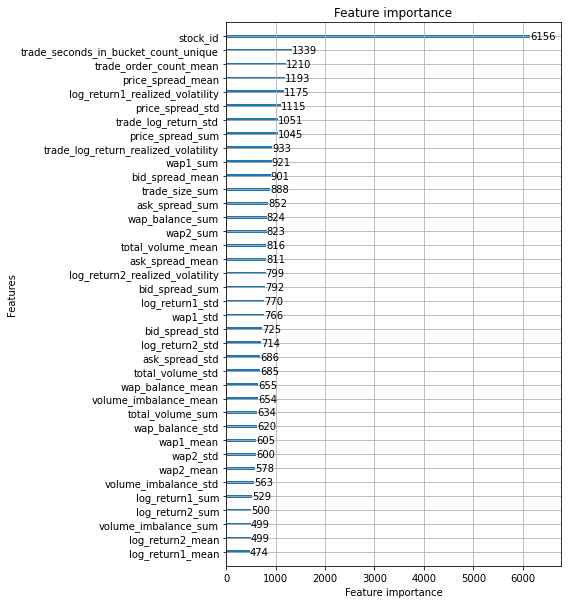

In [146]:
fig, ax = plt.subplots(figsize=(6,10))
lgb.plot_importance(model, ax=ax)
plt.show()

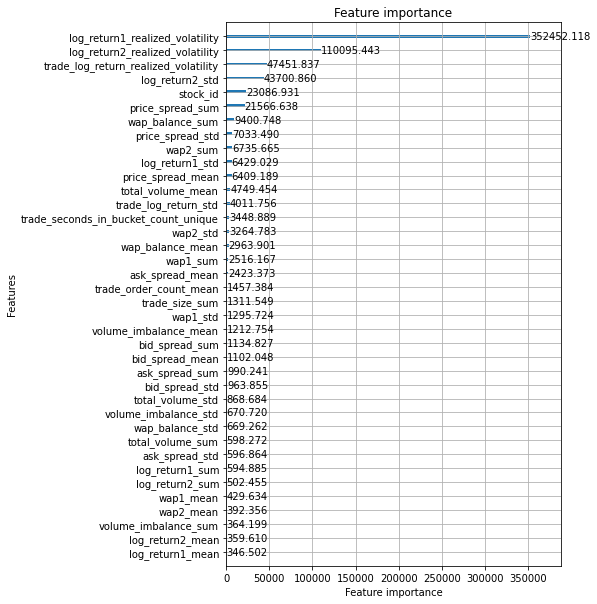

In [147]:
fig, ax = plt.subplots(figsize=(6,10))
lgb.plot_importance(model, ax=ax, importance_type='gain' )
plt.show()

# Featrue engenieering

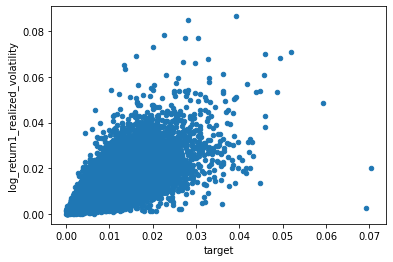

In [123]:
X_train.plot.scatter('target', 'log_return1_realized_volatility')

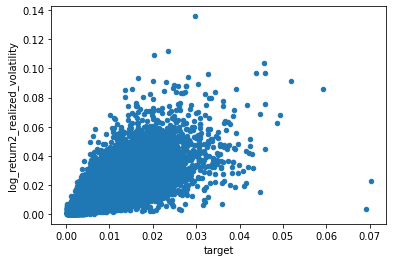

In [124]:
X_train.plot.scatter('target', 'log_return2_realized_volatility')

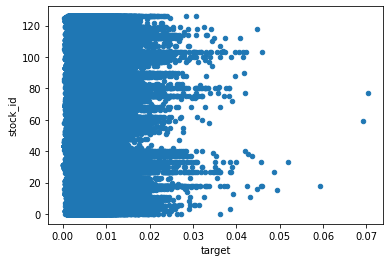

In [125]:
X_train.plot.scatter('target', 'stock_id')

In [ ]:
sns.pairplot(X_train[X_train['stock_id']==0])